In [1]:
import numpy as np
%matplotlib inline

import matplotlib.pyplot as plt
from tqdm import tqdm, trange

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

from torchvision.transforms import ToTensor, Resize, Compose
from torchvision import datasets
from collections import Counter

from her2_dataset import HER2Dataset
from patch_embedding import PatchEmbedding

transform = Compose([ToTensor(), Resize((224,224))])

torch.manual_seed(0)

IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_CHANNELS = 3
N_PATCHES = 16

MAX_CHECKPOINTS = 3

assert IMAGE_WIDTH%N_PATCHES==0

PATCH_WIDTH = IMAGE_WIDTH//N_PATCHES
PATCH_HEIGHT = IMAGE_HEIGHT//N_PATCHES


DATASET_PATH='../datasets/HER2_gastric_5classes'
# 20% of data goes to test
TEST_SPLIT = 0.2
BATCH_SIZE = 16

N_EPOCHS = 20
LR = 0.0001


/home/newt/miniconda3/envs/ds/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

dataset = HER2Dataset(DATASET_PATH, transform=transform)
train_dataset, test_dataset = dataset.genSplits(TEST_SPLIT)
train_loader, test_loader = dataset.getDataLoaders(BATCH_SIZE)

print(f"Dataset split:\nTrain: {len(train_dataset)}\nTest: {len(test_dataset)}")



Dataset split:
Train: 1627
Test: 406


Text(0.5, 1.0, 'Test Split')

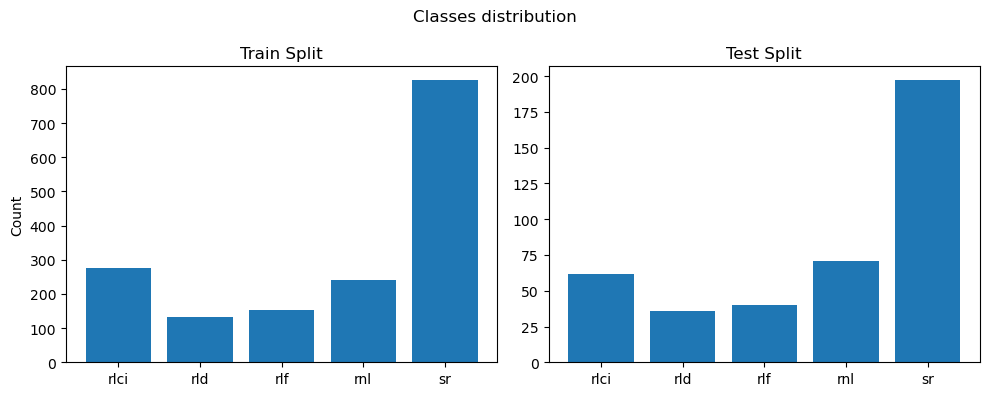

In [3]:
train_count, test_count = dataset.getSampleCountByClass()

fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(10,4))
fig.suptitle("Classes distribution")
ax[0].set_ylabel("Count")
ax[0].bar(list(zip(*train_count))[0], list(zip(*train_count))[1], tick_label=list(zip(*train_count))[2])
ax[0].set_title("Train Split")
ax[1].bar(list(zip(*test_count))[0], list(zip(*test_count))[1], tick_label=list(zip(*test_count))[2])
ax[1].set_title("Test Split")

In [5]:

data_iter = iter(train_loader)
images, labels = next(data_iter)
class_first_sample = list(map(lambda x: np.where(x == np.array(labels))[0][0], dataset.class_to_idx.values()))


print(images.shape)

fig, axes = plt.subplots(tight_layout=True, ncols=len(class_first_sample))
fig.suptitle("First sample of the dataset by class")

for ii in range(len(class_first_sample)):
    ax = axes[ii]
#     helper.imshow(images[ii], ax=ax, normalize=False)
    ax.set_title(dataset.classes[labels[class_first_sample[ii]]])
    ax.imshow(torch.transpose(images[class_first_sample[ii]], 0, 2))

IndexError: index 0 is out of bounds for axis 0 with size 0

KeyboardInterrupt: 

/home/newt/miniconda3/envs/ds/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


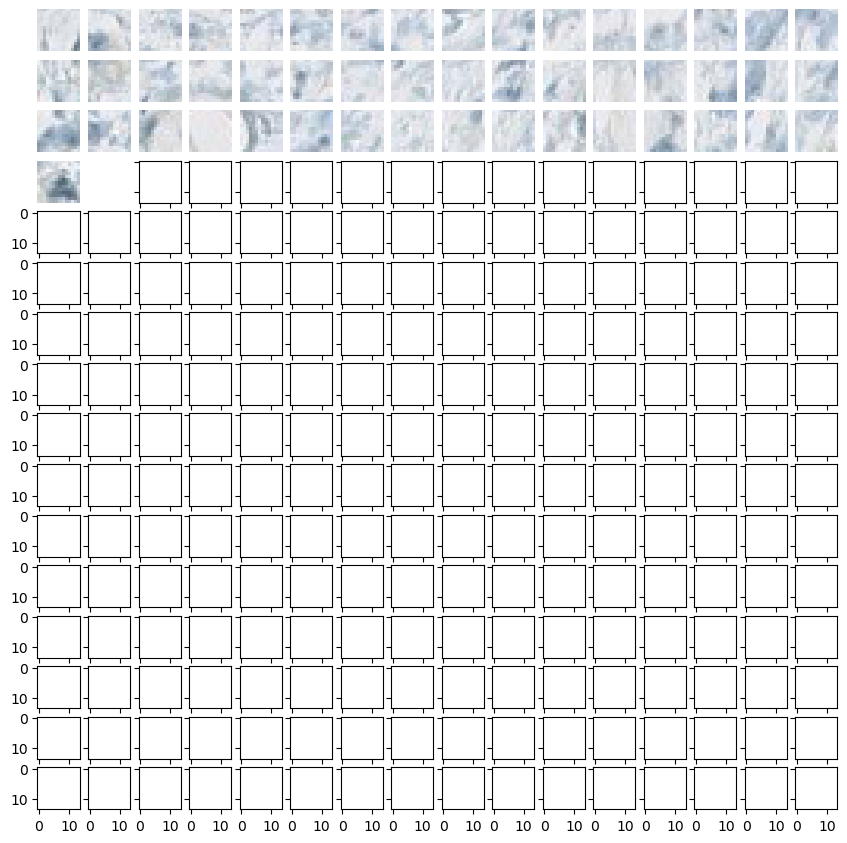

In [5]:
from patch_embedding import ImagePatcher


patcher = ImagePatcher(in_channels=IMAGE_CHANNELS, patch_size=IMAGE_WIDTH//N_PATCHES, img_size=IMAGE_HEIGHT)
gridSpec = dict(top = 1, bottom = 0, right = 1, left = 0, hspace = 0.2, wspace = 0.2)
data_iter = iter(train_loader)
images, labels = next(data_iter)
patches = patcher.toPatchesTensor(images[1].unsqueeze(0))
#patches = patches.reshape((1, N_PATCHES,N_PATCHES,23,23,3))
fig, axes = plt.subplots(N_PATCHES, N_PATCHES ,tight_layout=True, figsize=(8,8), sharex=True, sharey=True, gridspec_kw=gridSpec)
for i in range((N_PATCHES)):
    for j in range((N_PATCHES)):
        axes[i,j].axis('off')
        axes[i,j].set_aspect('equal')
        axes[i,j].imshow(patches[0, i, j], interpolation=None)


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")

print(f"ROI divided into regions of {IMAGE_WIDTH}x{IMAGE_HEIGHT}x{IMAGE_CHANNELS}\nUsing {N_PATCHES}x{N_PATCHES} patches of {PATCH_WIDTH}x{PATCH_HEIGHT}x{IMAGE_CHANNELS}")

import timm
model = timm.create_model('maxvit_tiny_rw_224', pretrained=True, num_classes=len(dataset.classes)).to(device)

pytorch_total_params = sum(p.numel() for p in model.parameters())
print(pytorch_total_params)

param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.2f}MB'.format(size_all_mb))


Using device:  cuda (NVIDIA GeForce RTX 3080)
ROI divided into regions of 224x224x3
Using 16x16 patches of 14x14x3


/home/newt/miniconda3/envs/ds/lib/python3.10/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


28546877
model size: 109.46MB


In [5]:
# Training loop
optimizer = Adam(model.parameters(), lr=LR)
criterion = CrossEntropyLoss()
for epoch in trange(N_EPOCHS, desc="Training"):
    train_loss = 0.0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1} in training", leave=False):
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = model(x)
        loss = criterion(y_hat, y)

        train_loss += loss.detach().cpu().item() / len(train_loader)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.2f}")

# Test loop
    with torch.no_grad():
        correct, total = 0, 0
        test_loss = 0.0
        for batch in tqdm(test_loader, desc="Testing"):
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)
            test_loss += loss.detach().cpu().item() / len(test_loader)

            correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
            total += len(x)
        print(f"Test loss: {test_loss:.2f}")
        print(f"Test accuracy: {correct / total * 100:.2f}%")


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20 loss: 0.91


Training:   5%|▌         | 1/20 [00:22<07:06, 22.47s/it]

Test loss: 0.66
Test accuracy: 71.92%


Epoch 2/20 loss: 0.50


Training:  10%|█         | 2/20 [00:43<06:27, 21.53s/it]

Test loss: 0.52
Test accuracy: 80.05%


Epoch 3/20 loss: 0.36


Training:  15%|█▌        | 3/20 [01:04<06:01, 21.26s/it]

Test loss: 0.54
Test accuracy: 81.28%


Epoch 4/20 loss: 0.21


Training:  20%|██        | 4/20 [01:25<05:39, 21.23s/it]

Test loss: 0.76
Test accuracy: 78.08%


Epoch 5/20 loss: 0.11


Training:  25%|██▌       | 5/20 [01:46<05:16, 21.11s/it]

Test loss: 0.61
Test accuracy: 81.53%


Epoch 6/20 loss: 0.10


Training:  30%|███       | 6/20 [02:07<04:56, 21.18s/it]

Test loss: 0.65
Test accuracy: 83.00%


Epoch 7/20 loss: 0.05


Training:  35%|███▌      | 7/20 [02:28<04:34, 21.10s/it]

Test loss: 0.78
Test accuracy: 84.48%


Epoch 8/20 loss: 0.05


Training:  40%|████      | 8/20 [02:49<04:13, 21.10s/it]

Test loss: 0.75
Test accuracy: 83.99%


Epoch 9/20 loss: 0.04


Training:  45%|████▌     | 9/20 [03:10<03:51, 21.08s/it]

Test loss: 0.75
Test accuracy: 83.99%


Epoch 10/20 loss: 0.05


Training:  50%|█████     | 10/20 [03:31<03:29, 20.98s/it]

Test loss: 0.71
Test accuracy: 84.48%


Epoch 11/20 loss: 0.05


Training:  55%|█████▌    | 11/20 [03:52<03:08, 20.94s/it]

Test loss: 0.97
Test accuracy: 79.80%


Epoch 12/20 loss: 0.06


Training:  60%|██████    | 12/20 [04:13<02:47, 20.91s/it]

Test loss: 0.70
Test accuracy: 83.99%


Epoch 13/20 loss: 0.04


Training:  65%|██████▌   | 13/20 [04:34<02:26, 20.92s/it]

Test loss: 0.74
Test accuracy: 82.51%


Epoch 14/20 loss: 0.00


Training:  70%|███████   | 14/20 [04:55<02:05, 20.93s/it]

Test loss: 0.78
Test accuracy: 84.73%


Epoch 15/20 loss: 0.00


Training:  75%|███████▌  | 15/20 [05:16<01:44, 20.93s/it]

Test loss: 0.66
Test accuracy: 85.71%


Epoch 16/20 loss: 0.00


Training:  80%|████████  | 16/20 [05:36<01:23, 20.94s/it]

Test loss: 0.77
Test accuracy: 85.47%


Epoch 17/20 loss: 0.00


Training:  85%|████████▌ | 17/20 [05:57<01:02, 20.94s/it]

Test loss: 0.79
Test accuracy: 86.95%


Epoch 18/20 loss: 0.00


Training:  90%|█████████ | 18/20 [06:18<00:41, 20.91s/it]

Test loss: 0.76
Test accuracy: 86.45%


Epoch 19/20 loss: 0.00


Training:  95%|█████████▌| 19/20 [06:39<00:20, 20.89s/it]

Test loss: 0.78
Test accuracy: 84.98%


Epoch 20/20 loss: 0.00


Training: 100%|██████████| 20/20 [07:00<00:00, 21.03s/it]

Test loss: 0.86
Test accuracy: 84.48%


In [6]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_loader:
    output = model(inputs.to(device)) # Feed Network

    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    y_pred.extend(output) # Save Prediction
    
    labels = labels.data.cpu().numpy()
    y_true.extend(labels) # Save Truth


['rlci', 'rld', 'rlf', 'rnl', 'sr']
              precision    recall  f1-score   support

           0       0.69      0.74      0.71        62
           1       0.79      0.83      0.81        36
           2       0.97      0.95      0.96        40
           3       0.75      0.63      0.69        71
           4       0.93      0.95      0.94       197

    accuracy                           0.85       406
   macro avg       0.83      0.82      0.82       406
weighted avg       0.85      0.85      0.85       406



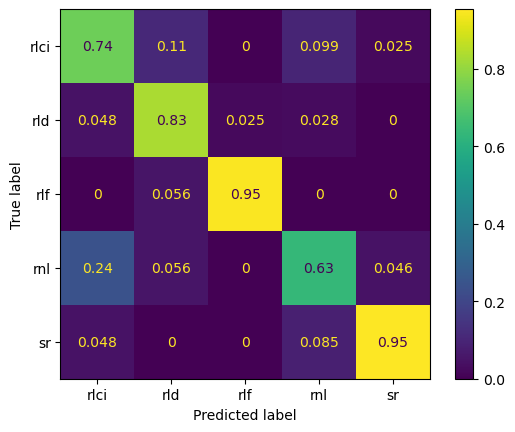

In [7]:
from sklearn.metrics import classification_report, plot_confusion_matrix, ConfusionMatrixDisplay
print(dataset.classes)
print(classification_report(y_pred=y_pred, y_true=y_true))
disp = ConfusionMatrixDisplay(confusion_matrix(y_pred=y_pred, y_true=y_true)/confusion_matrix(y_pred=y_pred, y_true=y_true).sum(axis=1), display_labels=dataset.classes)

disp.plot()